<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Cheap-memory-(don't-save-history)" data-toc-modified-id="Cheap-memory-(don't-save-history)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cheap memory (don't save history)</a></span></li></ul></div>

In [1]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

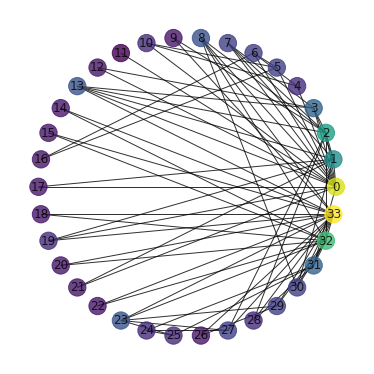

In [2]:
G = nx.karate_club_graph()

degree_centrality = nx.degree_centrality(G)
color_centrality = list(degree_centrality.values())

plt.figure(figsize=[5, 5])
nx.draw_circular(G, 
                 node_color=color_centrality,
                 alpha=0.8,
                 with_labels=True)
plt.show()



# More beautiful network

In [3]:
# Spring layout: closer is better connected
# pos = nx.spring_layout(G)

In [4]:
# Save network position
# np.savez('karateclub_pos.npz', pos=pos)

In [5]:
# Load previously saved network position
d = np.load('karateclub_pos.npz', allow_pickle=True)
pos = d['pos'].item()

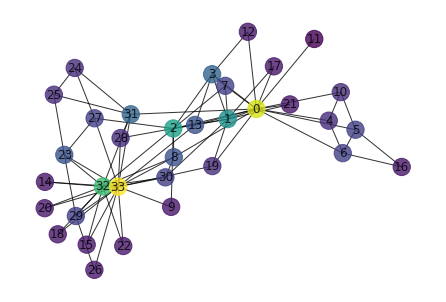

In [6]:
# Draw more beautiful network
nx.draw(G, 
        pos=pos, 
        node_color=color_centrality,
        alpha=0.8,
        with_labels=True)
plt.show()

In [7]:
def get_neighbors(G):
    neighbors = dict()
    for player in G.nodes():
        n_list = list(G.neighbors(player))  # neighbor list
        neighbors.update({player: n_list})
    return neighbors

def count_neighbors(neighbors):
    num_neighbors = dict()
    for player, n_list in neighbors.items():
        num_neighbors.update({player: len(n_list)})
    return num_neighbors

In [8]:
# edge list and adjacenc matrix
# other representations of the network
edge_list = list(G.edges()) 
adj = nx.convert_matrix.to_numpy_matrix(G)

# neighbor list for each person
neighbors = get_neighbors(G)
num_neighbors = count_neighbors(neighbors)
#
person = 2
print(f"person {person} has neighbors {neighbors[person]}")
print(f"person {person} has a total of {num_neighbors[person]} neighbors")
print(f"person {person} has degree centrality {degree_centrality[person] :.3f}")

person 2 has neighbors [0, 1, 3, 7, 8, 9, 13, 27, 28, 32]
person 2 has a total of 10 neighbors
person 2 has degree centrality 0.303


In [9]:
# sum of 2 = lose -> both get 0 points
# sum of 1 = D wins = #1 wins -> get "b" points > 1 :(
# sum of 0 = both collaborate = get 1 point
def get_points(role, pts_DD=0, pts_DC=1.3, pts_CC=1):
    """Points after a round of Prisoner's Dilemma on a network.
    0=collaborator, 1=defector. Sum of each pair of people.
    Rules:
        - sum=2 -> both lose     -> each gets pts_DD=0
        - sum=1 -> defector wins -> defector gets pts_DC=1.3
        - sum=0 -> both win      -> each gets pts_CC=1
    """
    points = np.zeros(G.number_of_nodes())
    for edge in edge_list:
        i, j = edge                   # persons i and j
        role_edge = role[list(edge)]  # defector=1 or collaborator=0?
        sum_edge = sum(role_edge)     # sum of each pair of people
        # examine interaction based on sum 
        if sum_edge == 0:
            points[i] += pts_CC  # both collaboration
            points[j] += pts_CC
        elif sum_edge == 2:
            points[i] += pts_DD
            points[j] += pts_DD  # both defect
        else:
            if role[i] == 1: # i is defector
                points[i] += pts_DC
            else:            # j is defector
                points[j] += pts_DC
    return points

def get_new_mutrole(role, neighbors, points_norm, G, p_m = 0):
    """Adopt the strategy of whoever is winning of your neighbors 
    and look at yourself. Make error with choosing role with mutation 
    value set by p_m"""
    new_role = np.zeros(len(role))
    for player in range(G.number_of_nodes()):
        n_list = neighbors[player].copy()
        n_list.append(player)
        # n_list = n_list[::-1]  # keep your own role
        n_pts = points_norm[n_list]
        n_roles = role[n_list]
        max_pts = max(n_pts)
        all_winners_index = np.argwhere(n_pts==max_pts).flatten()
        all_winners_players = np.array(n_list)[all_winners_index]
        all_winners_roles = n_roles[all_winners_index]
        # select 1 winner
        # winner = np.random.choice(all_winners_players)
        winner = all_winners_players[0]  # choose self
        winner_role = role[winner]
        # add randomness 
        if np.random.rand() < p_m:
            new_role[player] = (winner_role + 1) % 2
        else:
            new_role[player] = winner_role 
    return new_role

In [10]:
# Adopt the strategy of whoever is winning of your neighbors
# also look at yourself
# def get_new_role(role, neighbors, points_norm, G):
#     new_role = np.zeros(len(role))
#     for player in range(G.number_of_nodes()):
#         n_list = neighbors[player].copy()
#         n_list.append(player)
#         # n_list = n_list[::-1]  # keep your own role
#         n_pts = points_norm[n_list]
#         n_roles = role[n_list]
#         max_pts = max(n_pts)
#         all_winners_index = np.argwhere(n_pts==max_pts).flatten()
#         all_winners_players = np.array(n_list)[all_winners_index]
#         all_winners_roles = n_roles[all_winners_index]
#         # select 1 winner
#         # winner = np.random.choice(all_winners_players)
#         winner = all_winners_players[0]
#         winner_role = role[winner]
#         # add randomness 
#         new_role[player] = winner_role
#     return new_role



In [11]:
def draw_defectors(G, pos, role, best=[], color_C='g', color_D='r'):
    colors = []
    sizes = []
    for v in G.nodes():
        if role[v] == 1:
            color = color_D
        else:
            color = color_C
        colors.append(color)
        if v in best:
            size = 500
        else:
            size = 100
        sizes.append(size)
    nx.draw(G, pos=pos, with_labels=True, 
            node_color=colors, 
            alpha=0.8, 
            node_size=sizes)
    plt.show()
    pass

# Initialize

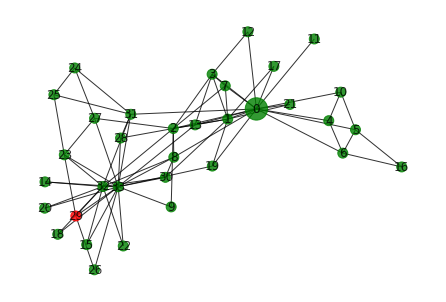

In [12]:
# Build intitial Defector distribution
num_defectors = 1
member_index = list(range(G.number_of_nodes()))
init_Ds = np.random.choice(member_index, num_defectors, replace=False)

role = np.zeros([G.number_of_nodes()])  # 0 = collaborator
role[init_Ds] = 1                       # 1 = defector

draw_defectors(G, pos, role, [0])

# Play a couple rounds

round 1


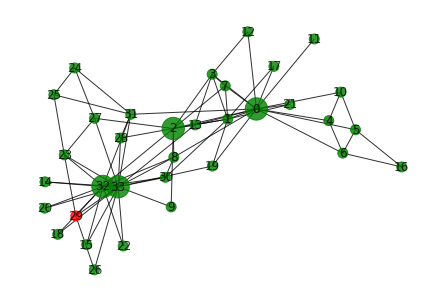

round 2


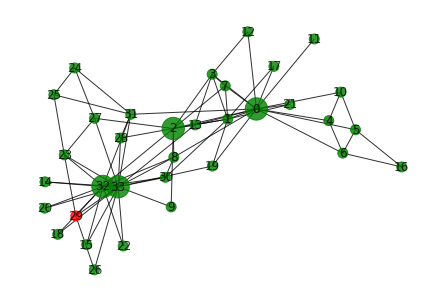

round 3


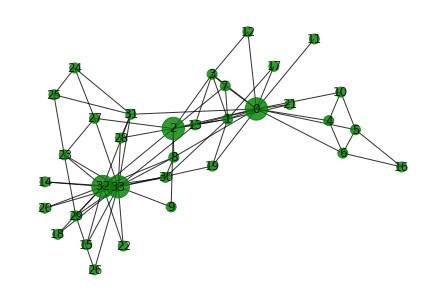

round 4


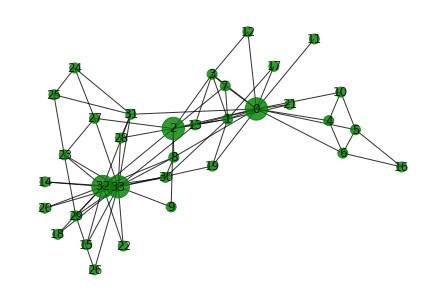

round 5


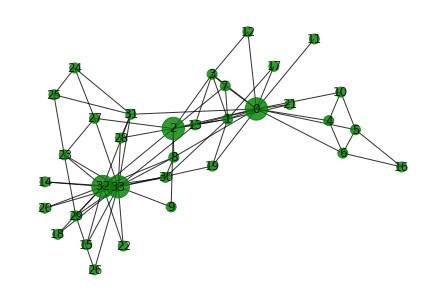

round 6


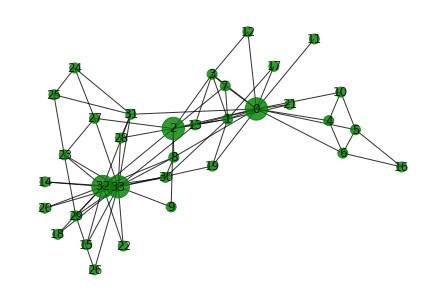

round 7


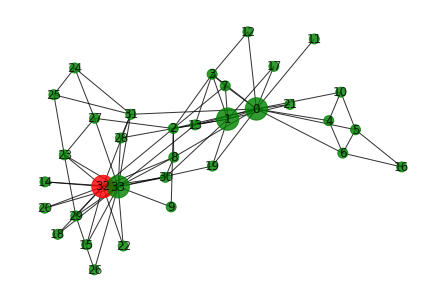

round 8


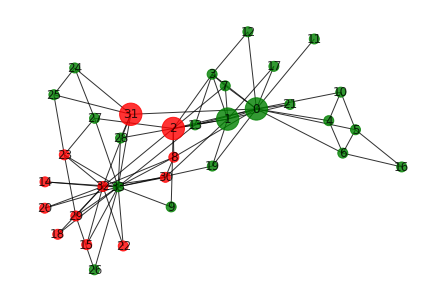

round 9


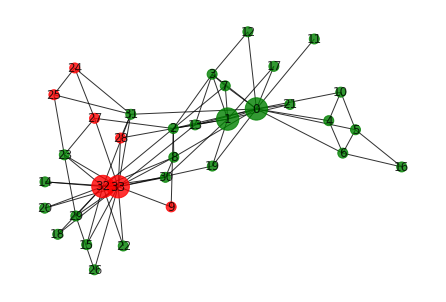

round 10


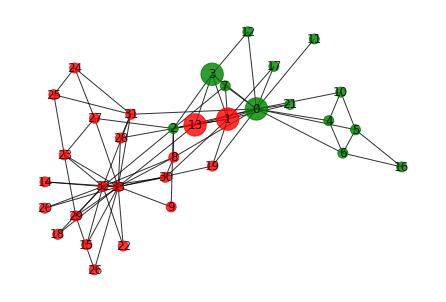

round 11


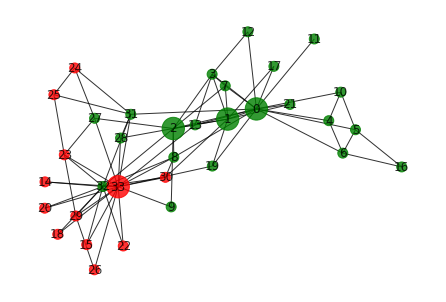

round 12


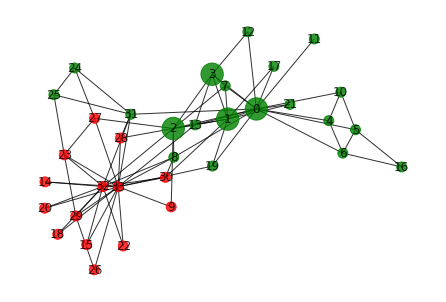

In [13]:
# Play a couple rounds.
# Defectors drawn as red, collaborators drawn as green
# by default. 
# Best 4 players are shown big.
num_rounds = 12
role_history = np.zeros([num_rounds + 1, G.number_of_nodes()])
# initialization
old_role = role.copy()
role_history[0, :] = old_role  # initialization is 1st row
# save memory by replacing role_history with num_defectors
num_defectors = [sum(old_role)]  
for round in range(1, num_rounds + 1):
    # Play the game
    points = get_points(old_role, pts_DC = 1.4)
    new_role = get_new_mutrole(old_role, neighbors, points, 
                               G, p_m = 0.01)
    # Save results
    role_history[round, :] = new_role
    num_defectors.append(sum(new_role)) # less data used
    # removed normalization by popularity
    # points_norm = points / np.array(list(player_numneighbors.values()))
    # Top 4 players
    points_rank = np.argsort(points)[::-1]
    best4 = points_rank[0:4]
    # Draw result
    print(f"round {round}")
    draw_defectors(G, pos, old_role, best4)
    # Update network
    old_role = new_role

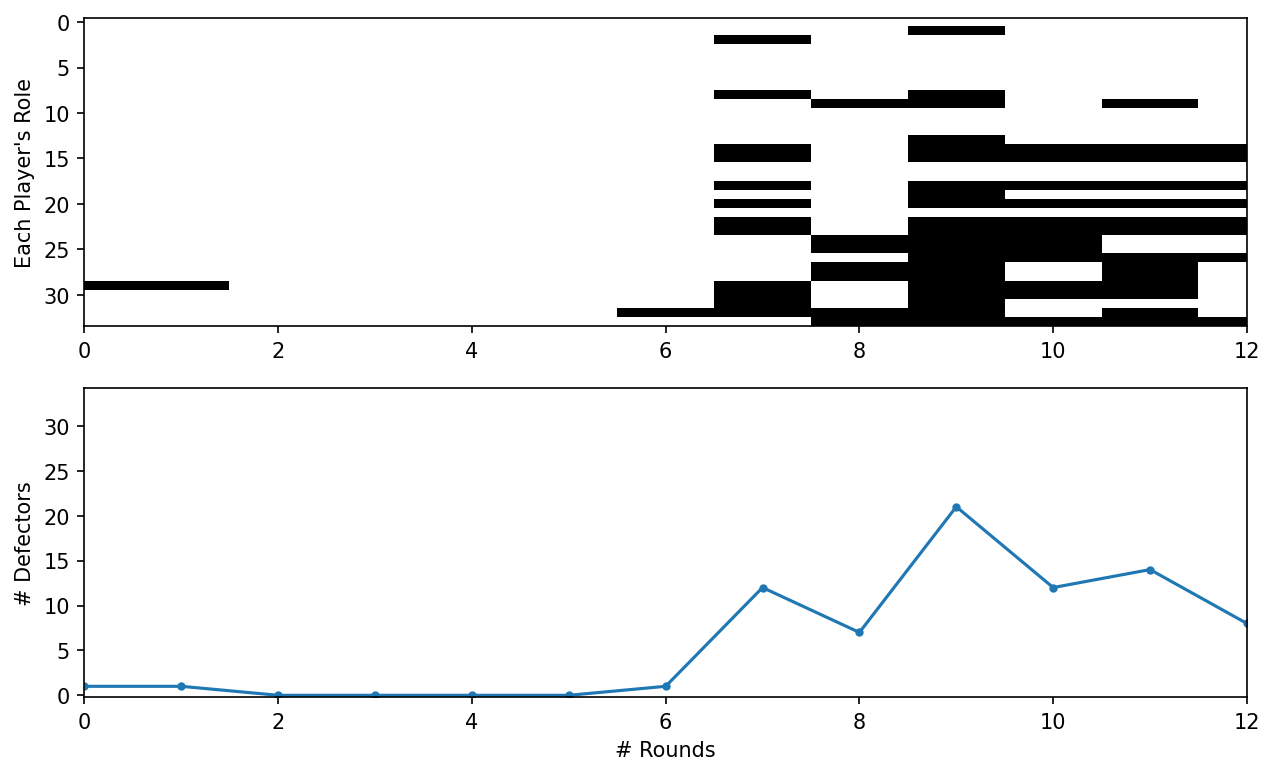

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[10, 6],
                               dpi=150)

ax1.imshow(role_history.T, cmap='Greys', aspect='auto')
ax2.plot(num_defectors, '.-')
ax2.set_ylim([0-0.2, G.number_of_nodes()+0.2])
for ax in [ax1, ax2]:
    ax.set_xlim([0, num_rounds])
#
ax1.set_ylabel("Each Player's Role")
ax2.set_xlabel('# Rounds')
ax2.set_ylabel('# Defectors')
plt.show()

# Play more rounds

round 100


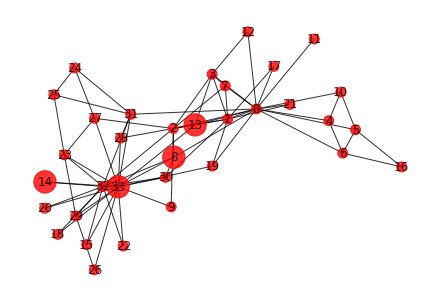

round 200


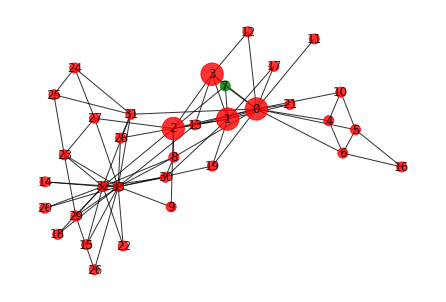

round 300


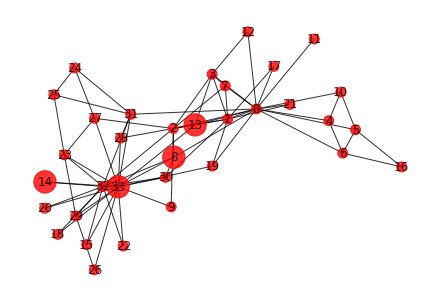

round 400


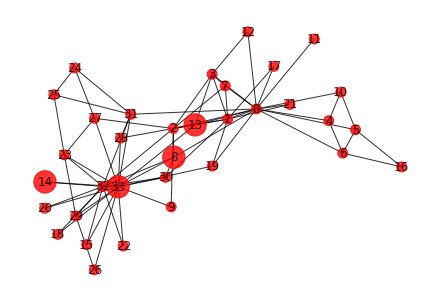

round 500


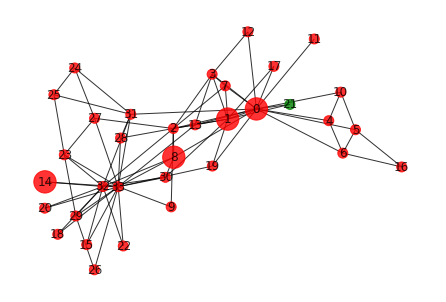

round 600


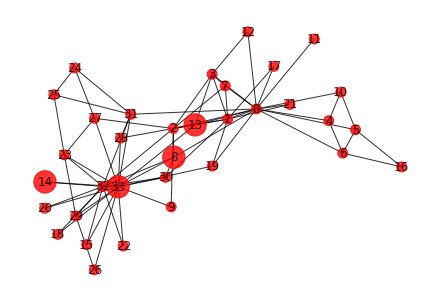

round 700


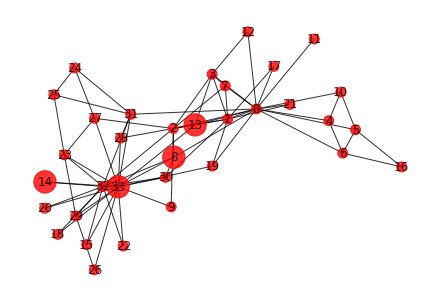

round 800


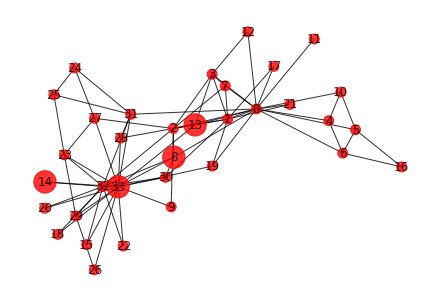

round 900


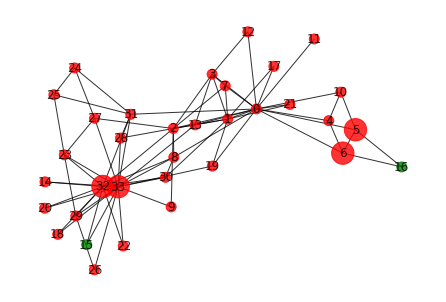

round 1000


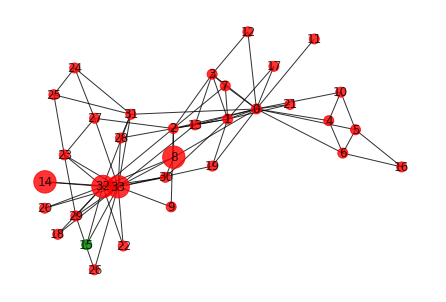

In [15]:
num_rounds = 1000  # Play many more rounds
show_rounds = 100  # Only show some rounds
role_history = np.zeros([num_rounds + 1, G.number_of_nodes()])
# initialization
old_role = role.copy()
role_history[0, :] = old_role  # initialization is 1st row
# save memory by replacing role_history with num_defectors
num_defectors = [sum(old_role)]  
for round in range(1, num_rounds + 1):
    # Play the game
    points = get_points(old_role, pts_DC = 1.4)
    new_role = get_new_mutrole(old_role, neighbors, points, 
                               G, p_m = 0.01)
    # Save results
    role_history[round, :] = new_role
    num_defectors.append(sum(new_role)) # less data used
    # Only show some rounds
    if round % show_rounds == 0:
        # Top 4 players
        points_rank = np.argsort(points)[::-1]
        best4 = points_rank[0:4]
        # Draw result
        print(f"round {round}")
        draw_defectors(G, pos, old_role, best4)
    # Update network
    old_role = new_role

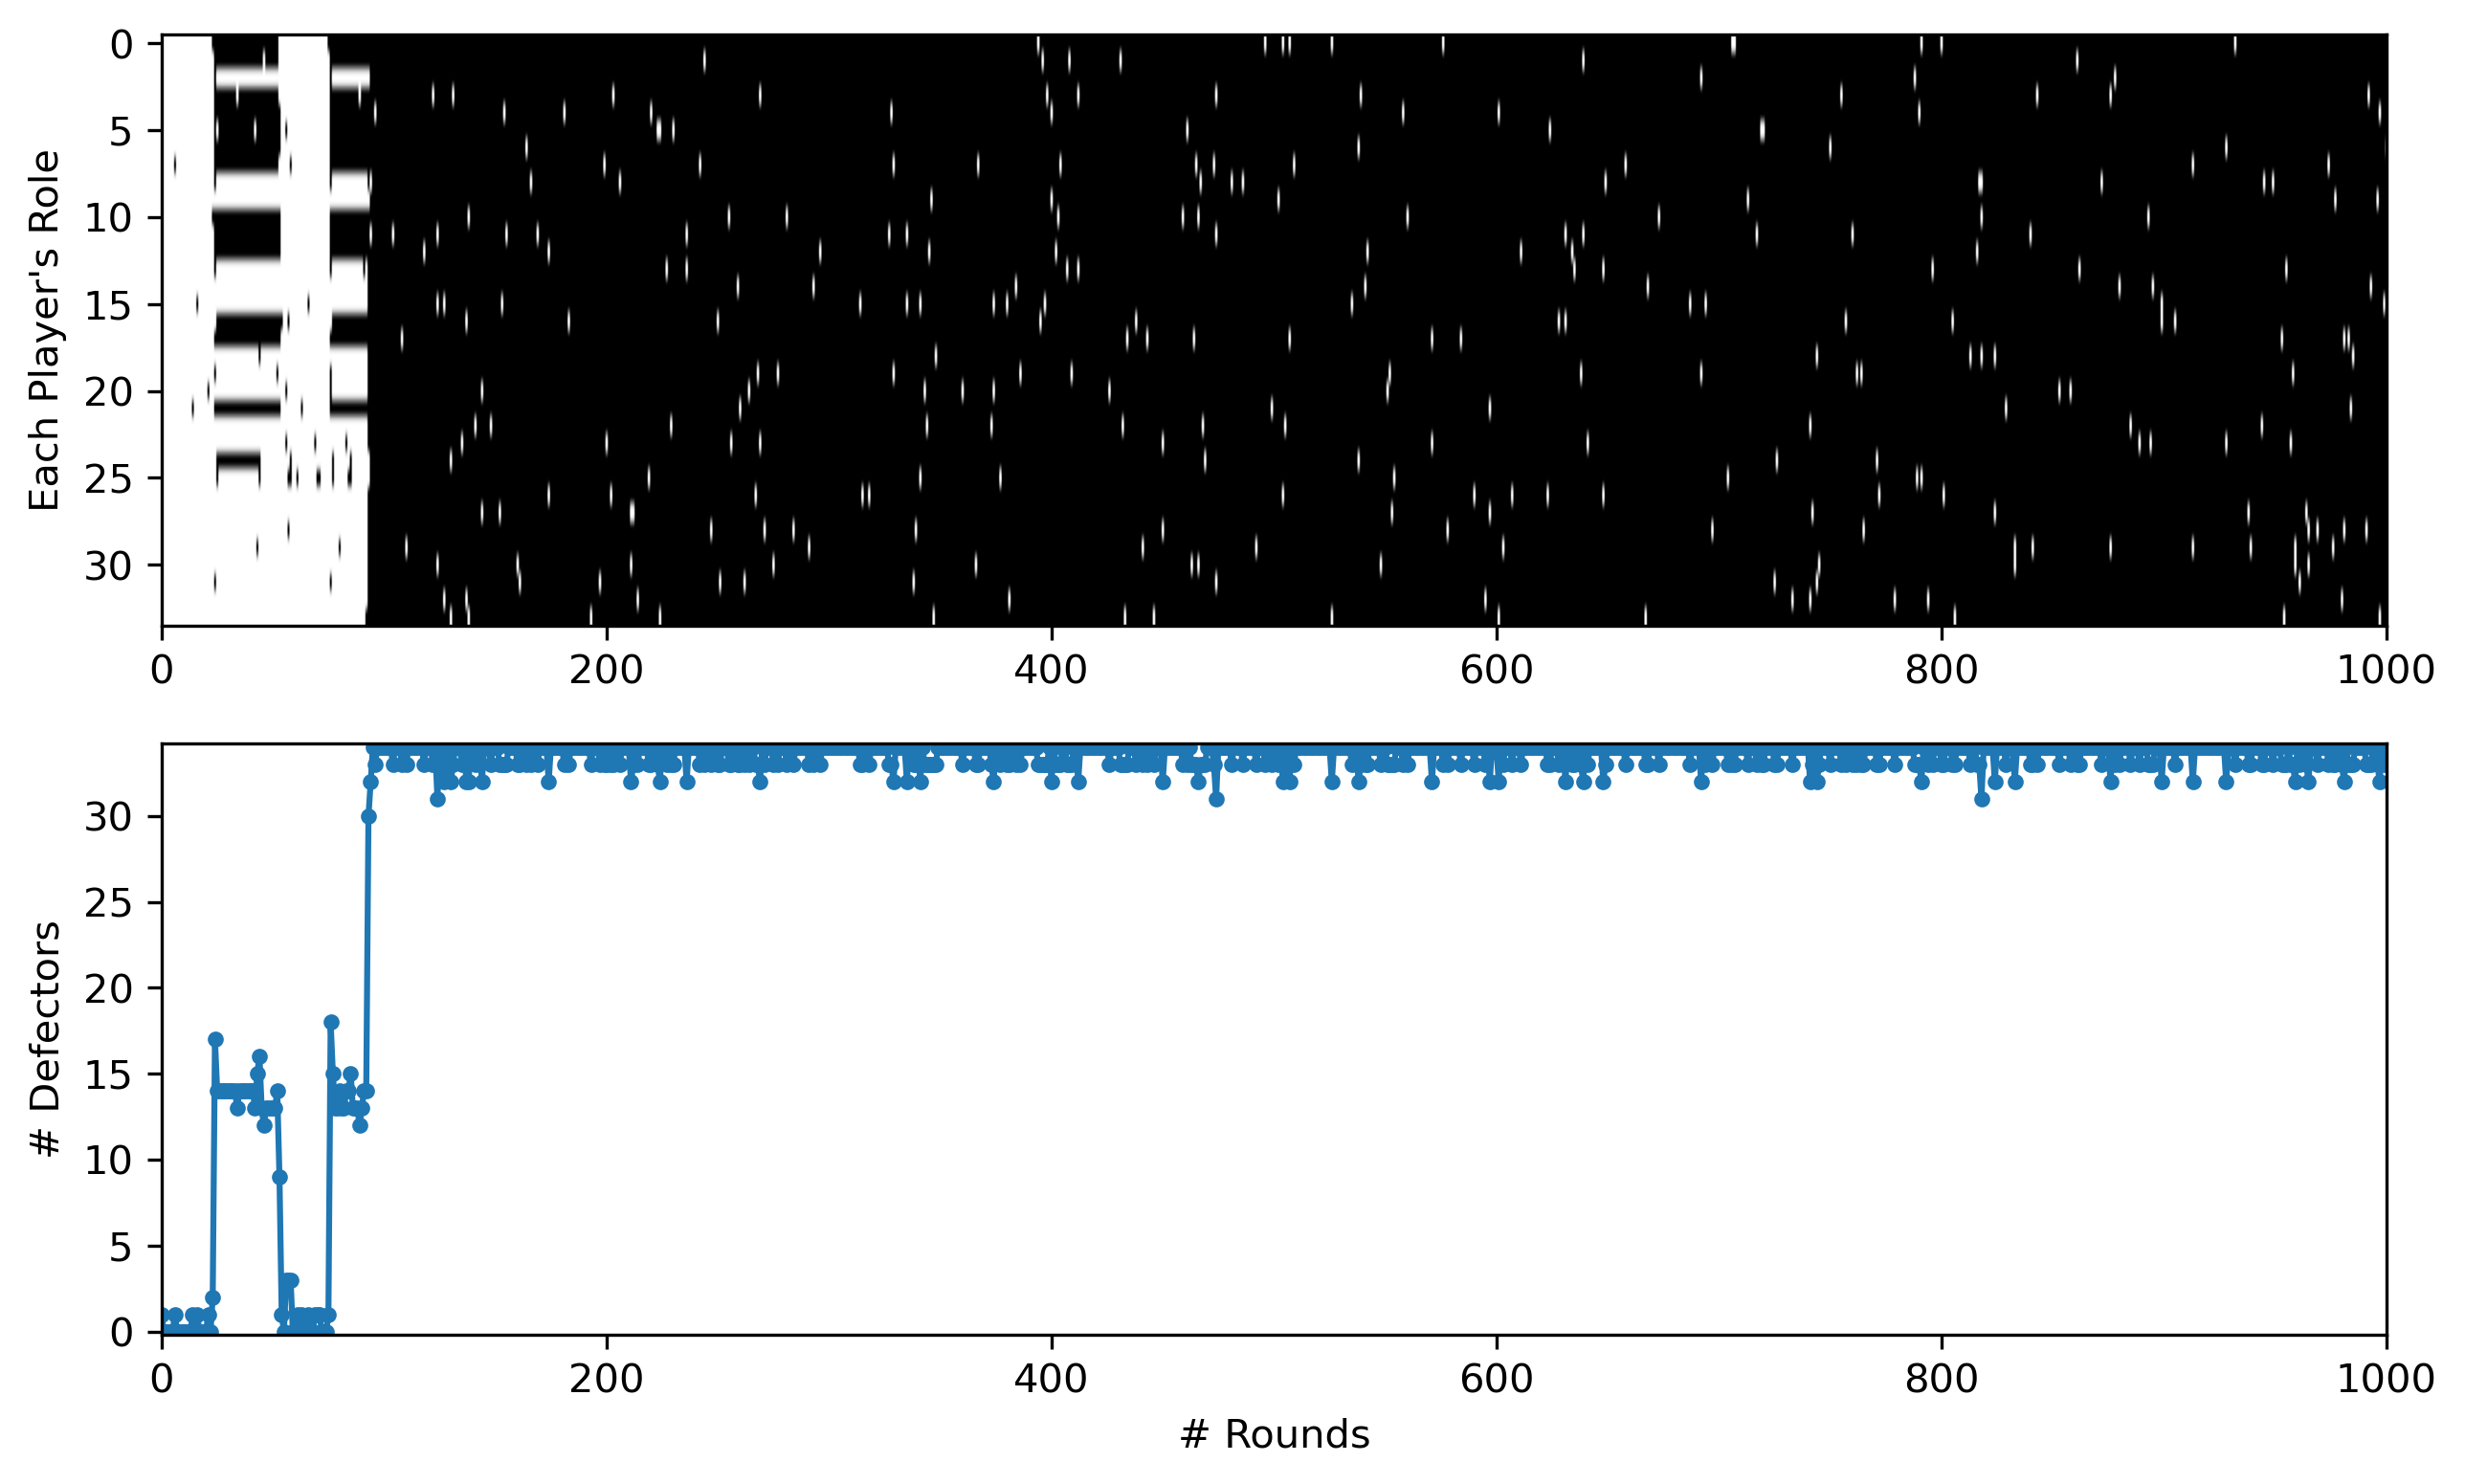

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[10, 6],
                               dpi=300)

ax1.imshow(role_history.T, cmap='Greys', aspect='auto')
ax2.plot(num_defectors, '.-')
ax2.set_ylim([0-0.2, G.number_of_nodes()+0.2])
for ax in [ax1, ax2]:
    ax.set_xlim([0, num_rounds])
#
ax1.set_ylabel("Each Player's Role")
ax2.set_xlabel('# Rounds')
ax2.set_ylabel('# Defectors')
plt.show()

# Play a LOT of rounds

round 10000


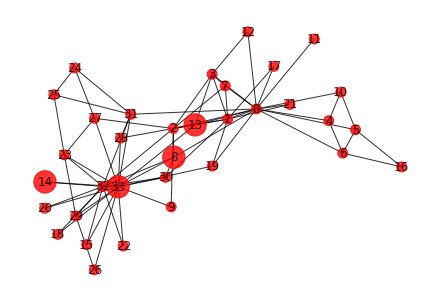

round 20000


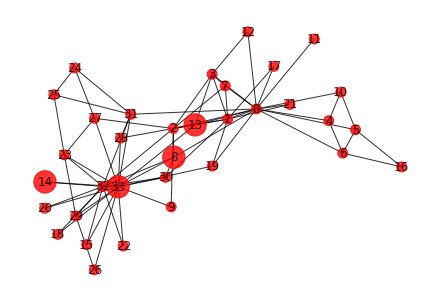

round 30000


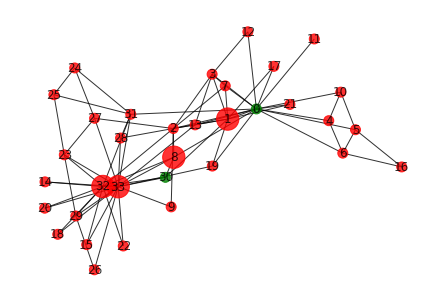

round 40000


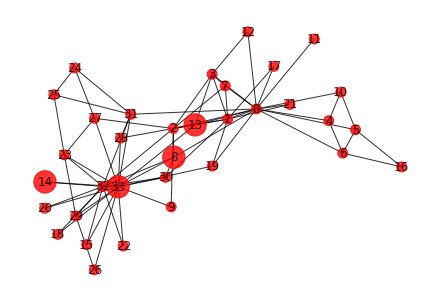

round 50000


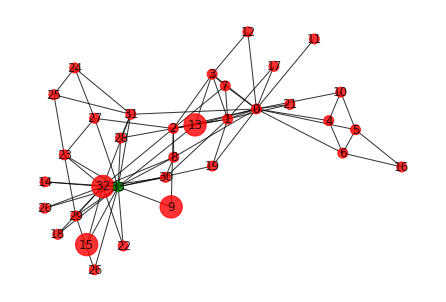

round 60000


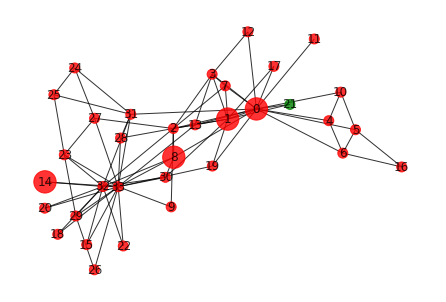

round 70000


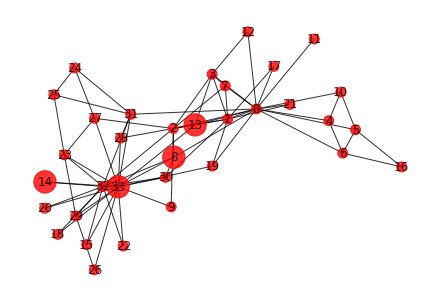

round 80000


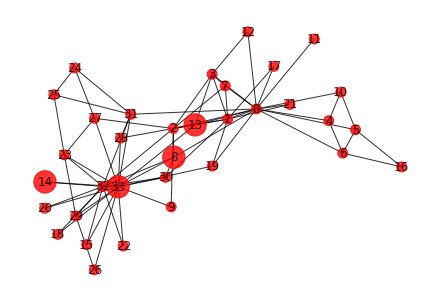

round 90000


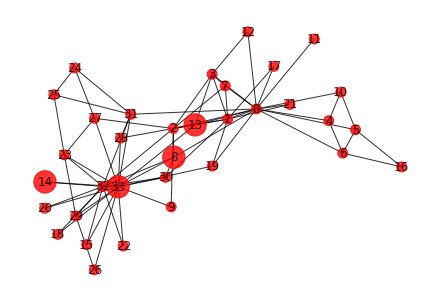

round 100000


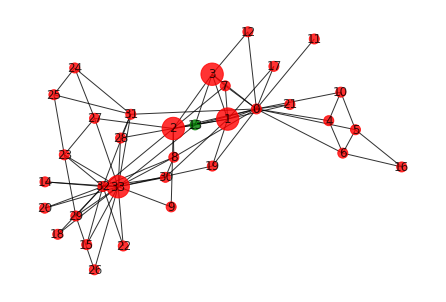

round 110000


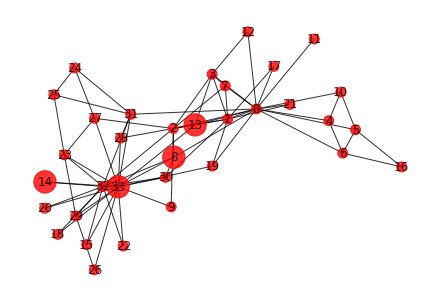

round 120000


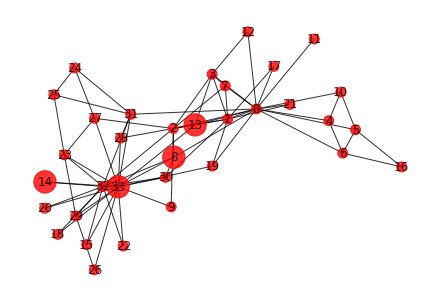

round 130000


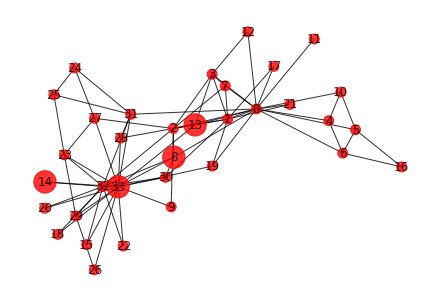

round 140000


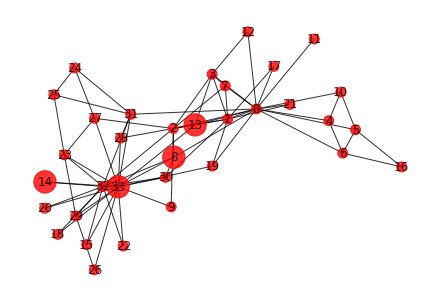

round 150000


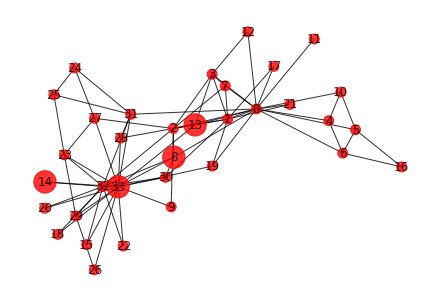

round 160000


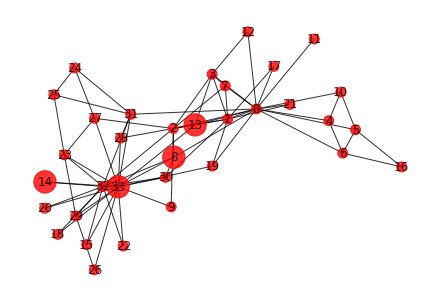

round 170000


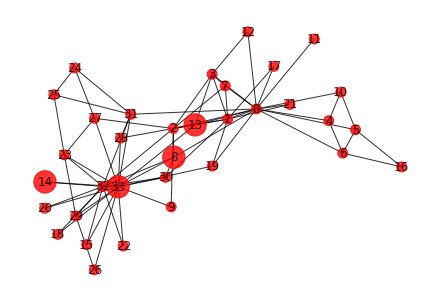

round 180000


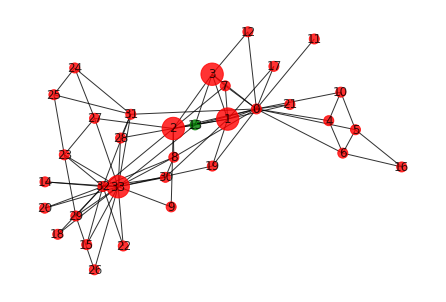

round 190000


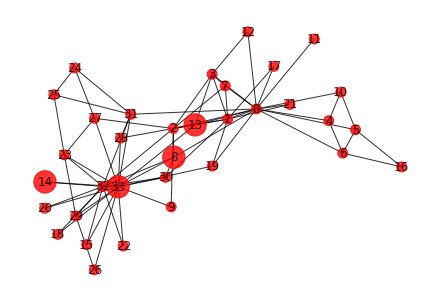

round 200000


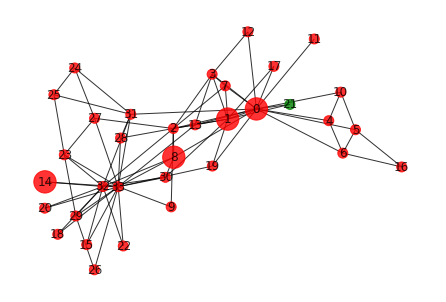

round 210000


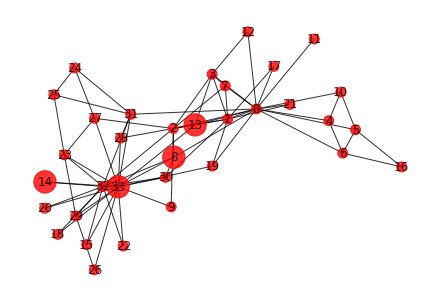

round 220000


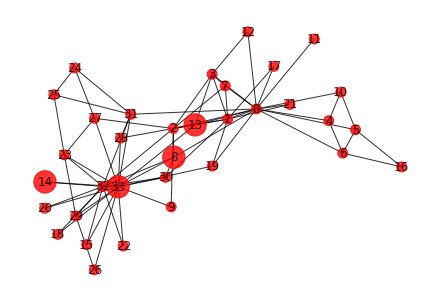

round 230000


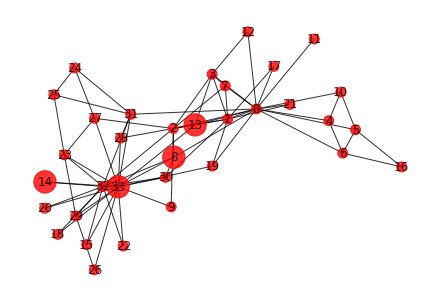

round 240000


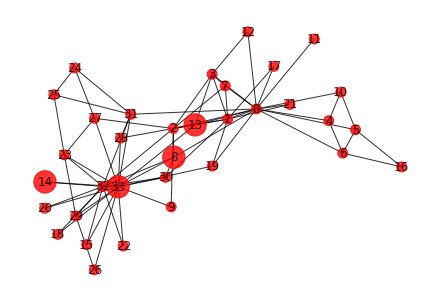

round 250000


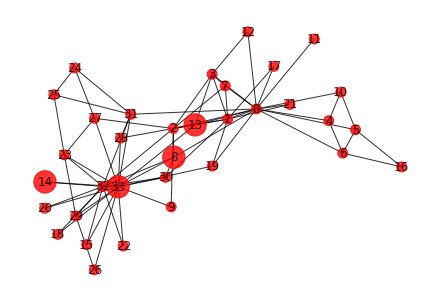

round 260000


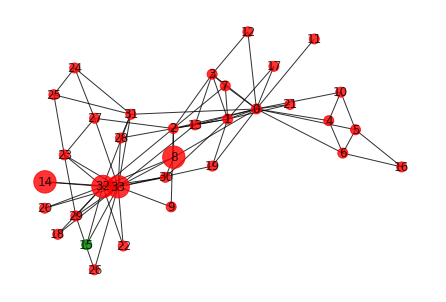

round 270000


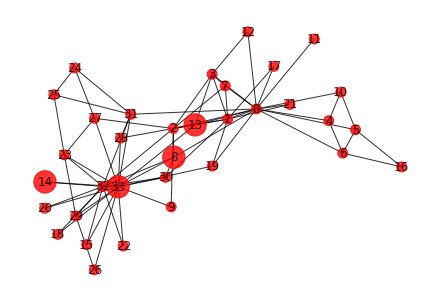

round 280000


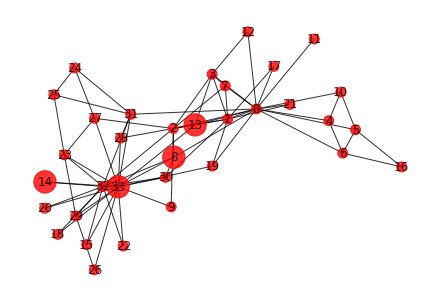

round 290000


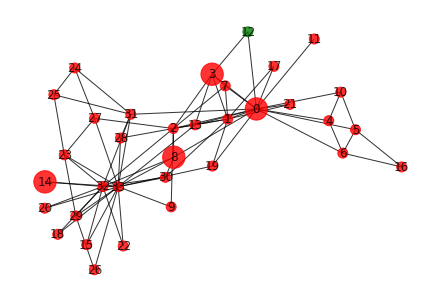

round 300000


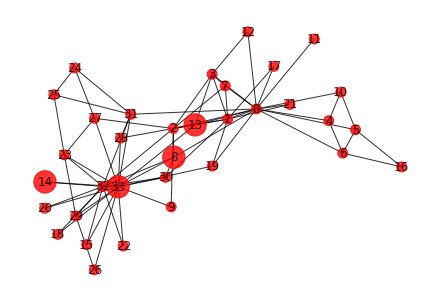

round 310000


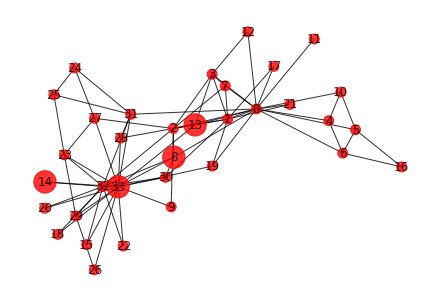

round 320000


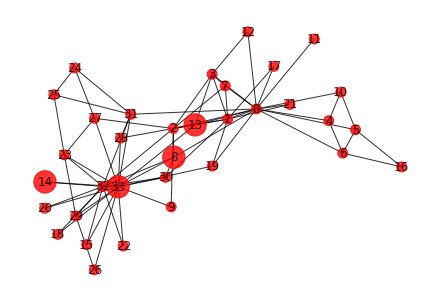

round 330000


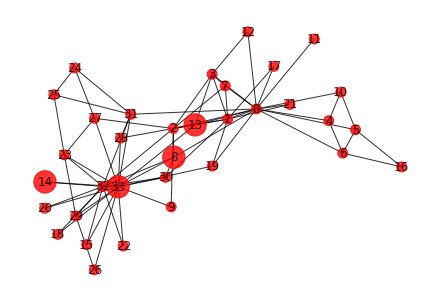

round 340000


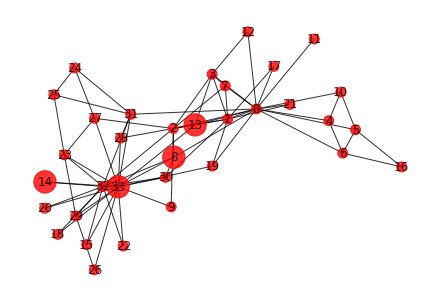

round 350000


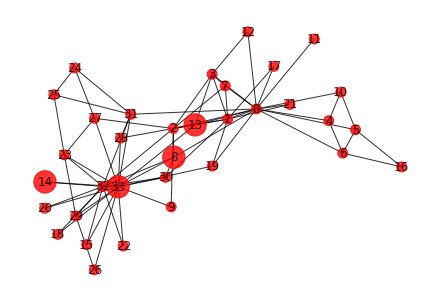

round 360000


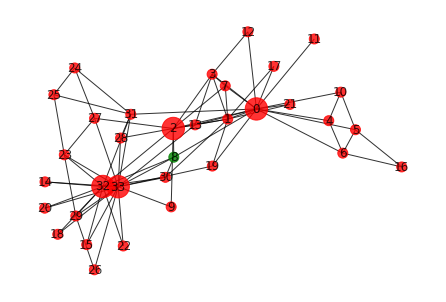

round 370000


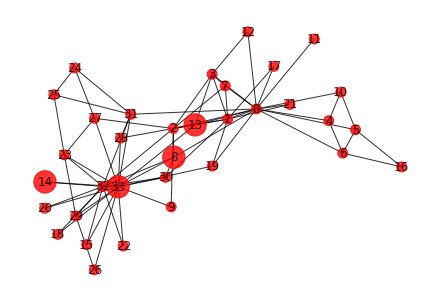

round 380000


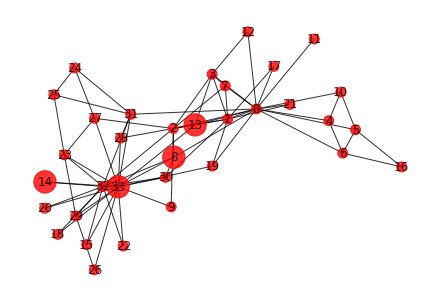

round 390000


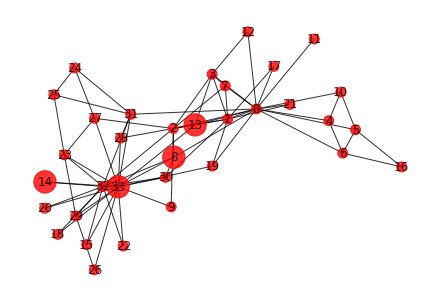

round 400000


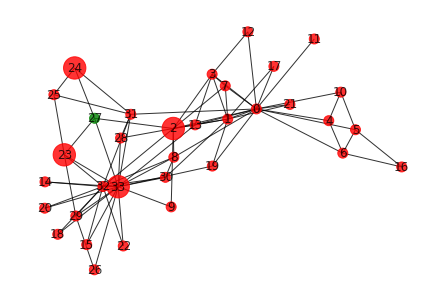

round 410000


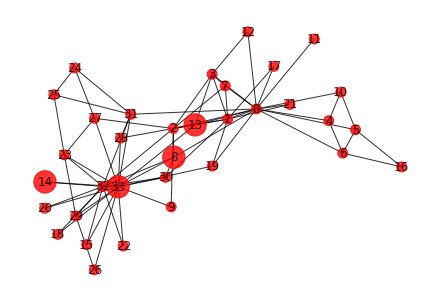

round 420000


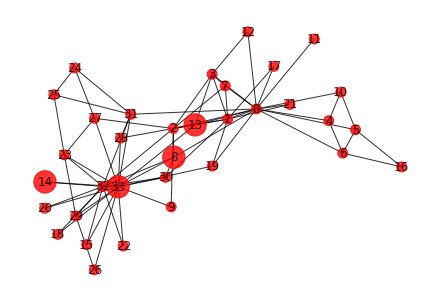

round 430000


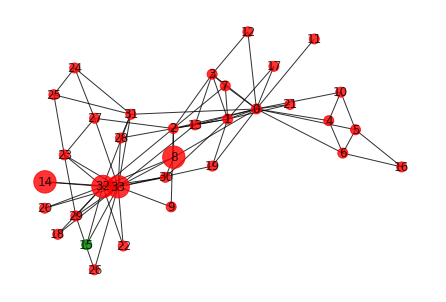

round 440000


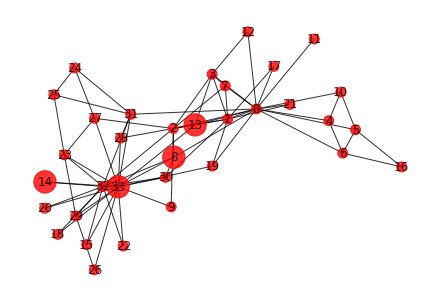

round 450000


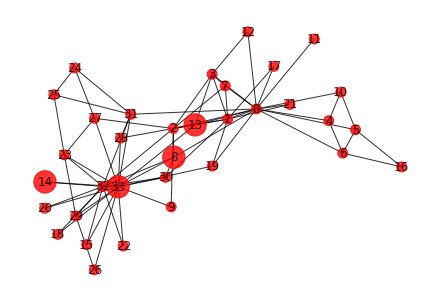

round 460000


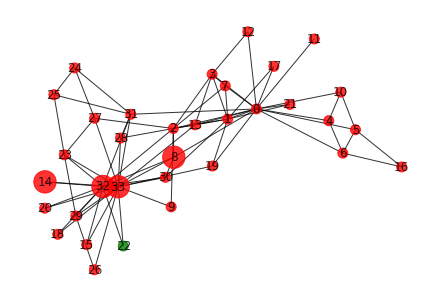

round 470000


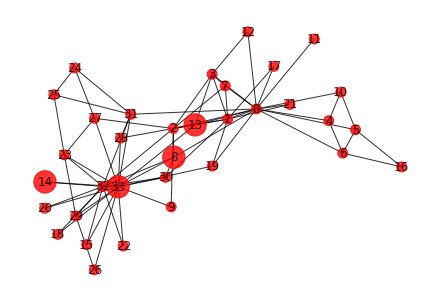

round 480000


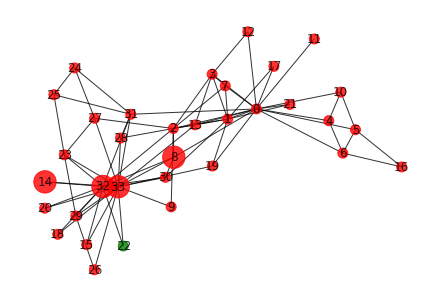

round 490000


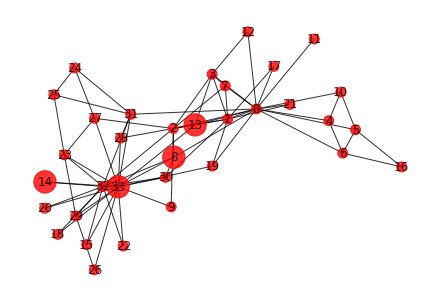

round 500000


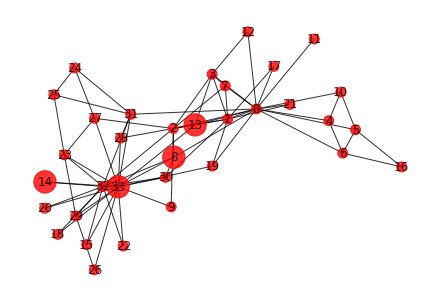

round 510000


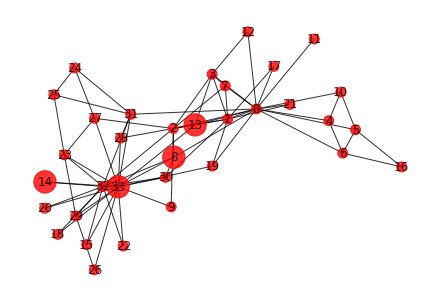

round 520000


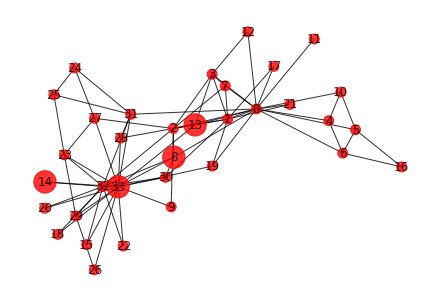

round 530000


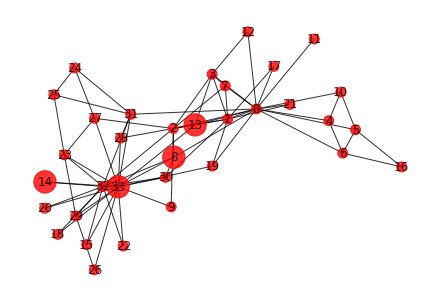

round 540000


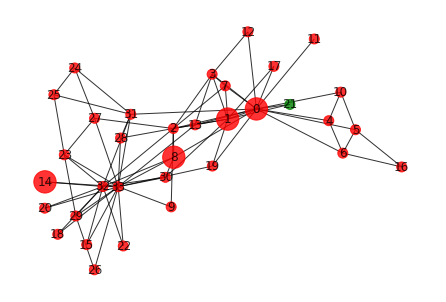

round 550000


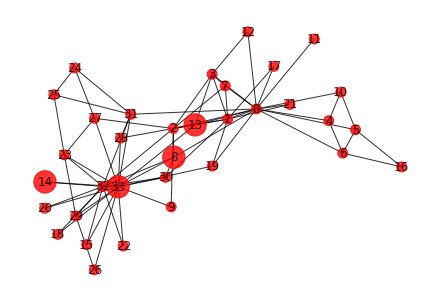

round 560000


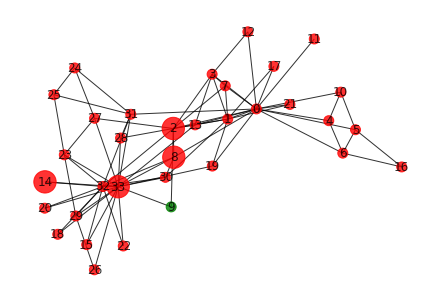

round 570000


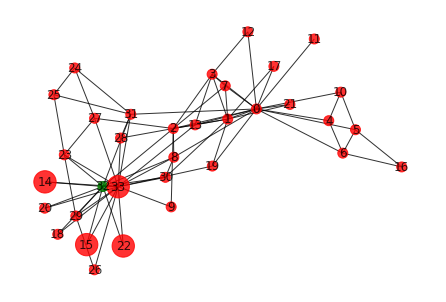

round 580000


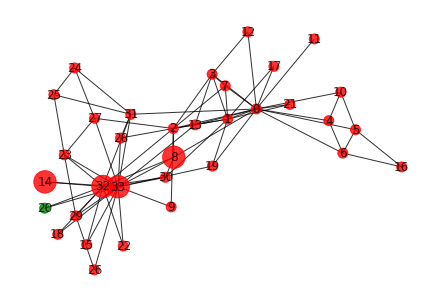

round 590000


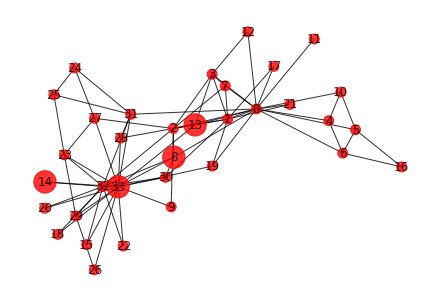

round 600000


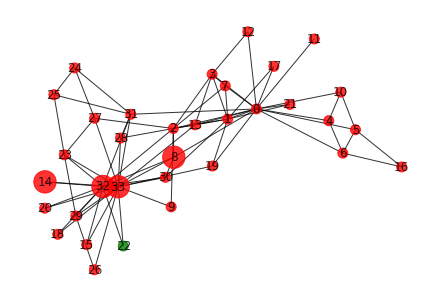

round 610000


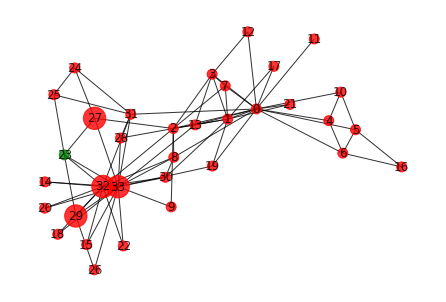

round 620000


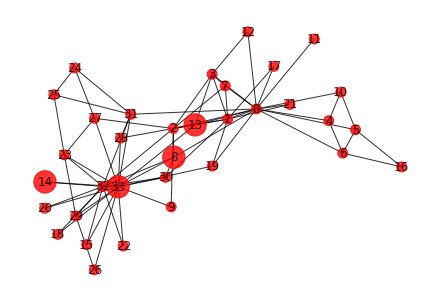

round 630000


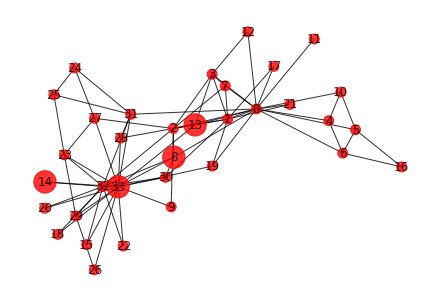

round 640000


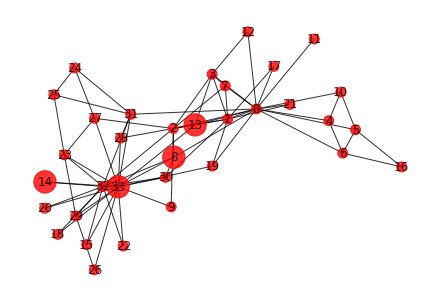

round 650000


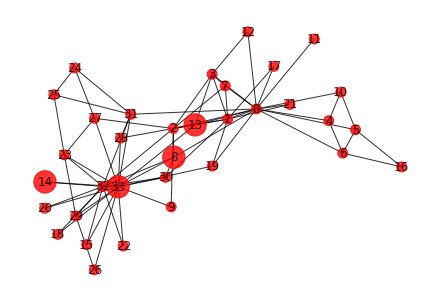

round 660000


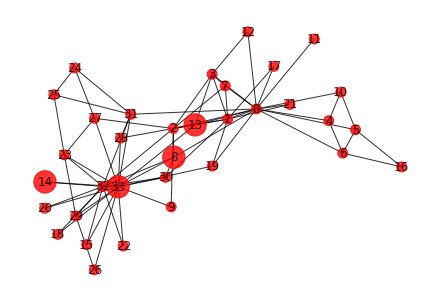

round 670000


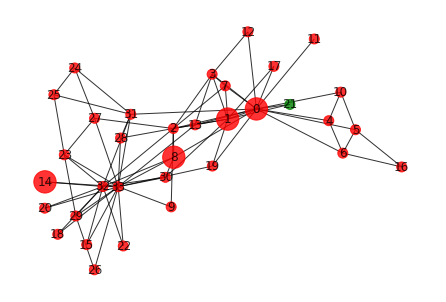

round 680000


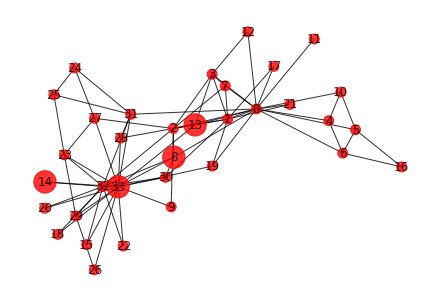

round 690000


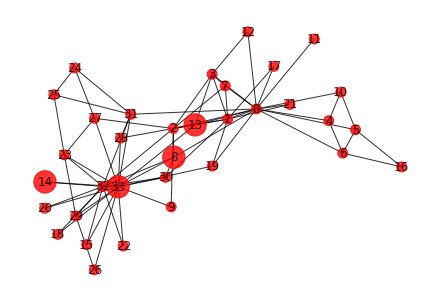

round 700000


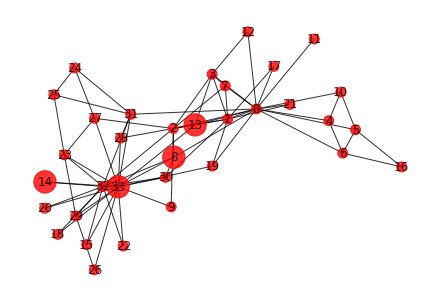

round 710000


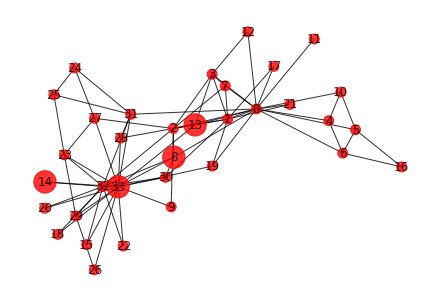

round 720000


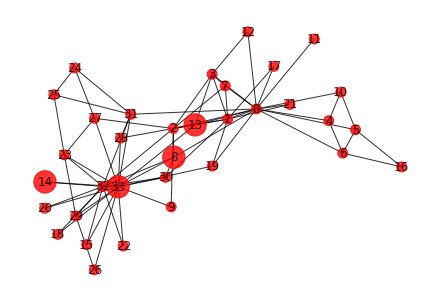

round 730000


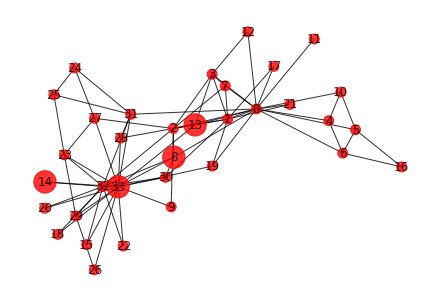

round 740000


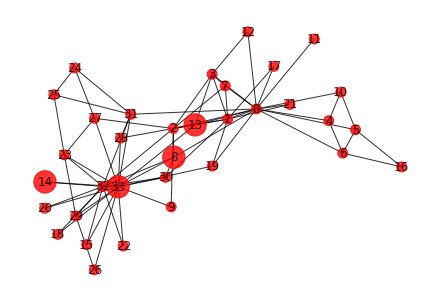

round 750000


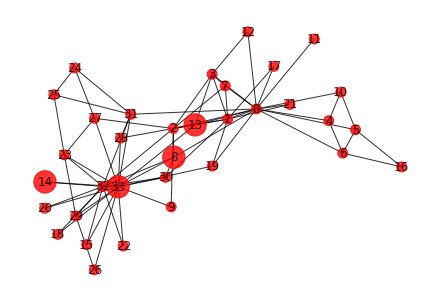

round 760000


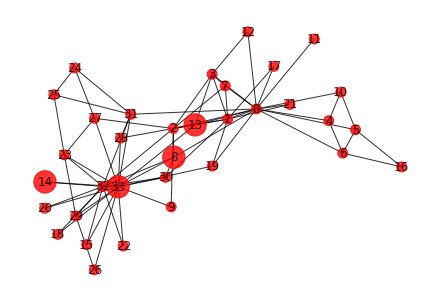

round 770000


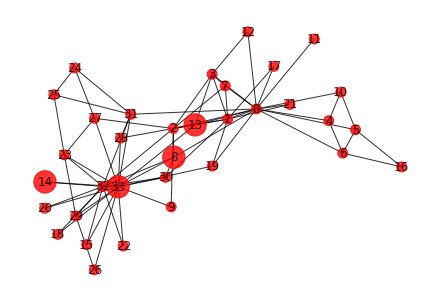

round 780000


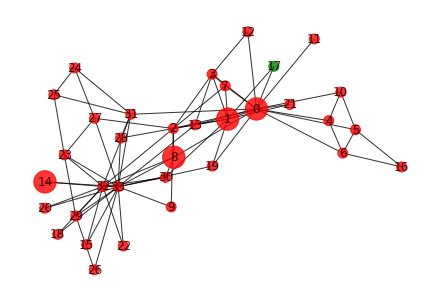

round 790000


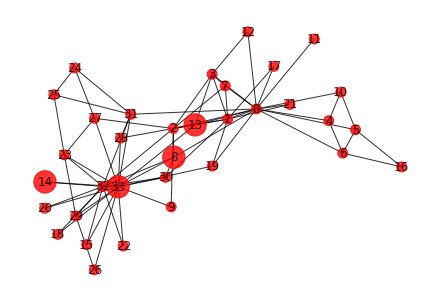

round 800000


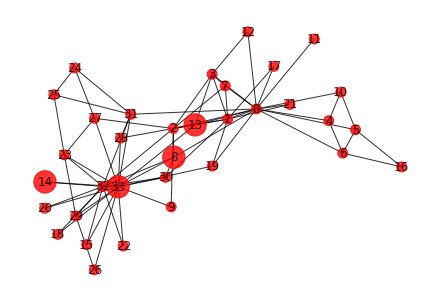

round 810000


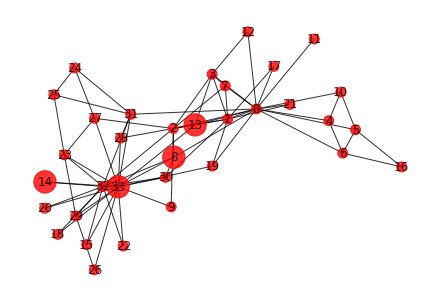

round 820000


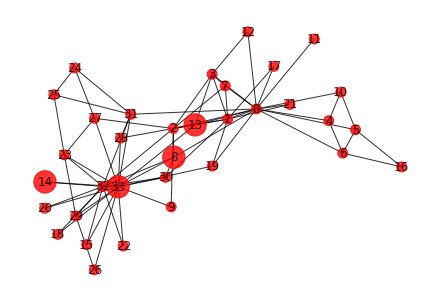

round 830000


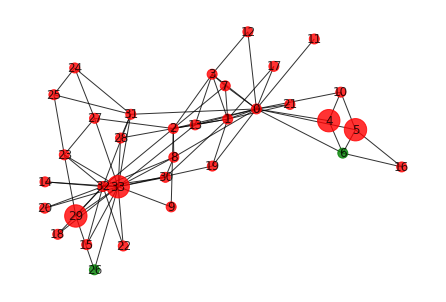

round 840000


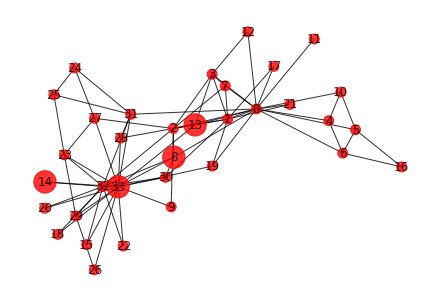

round 850000


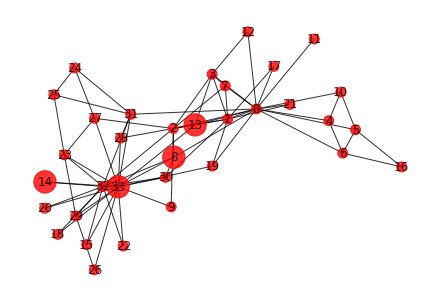

round 860000


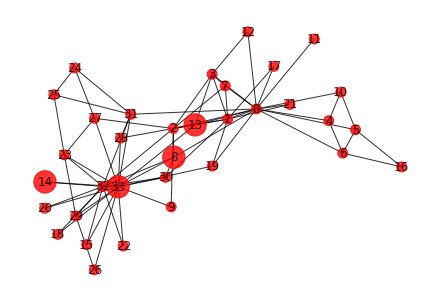

round 870000


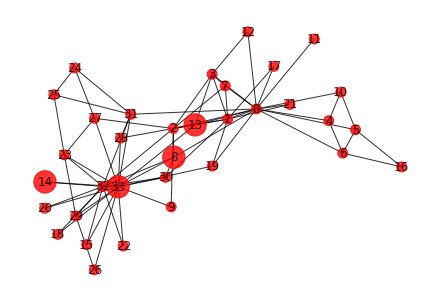

round 880000


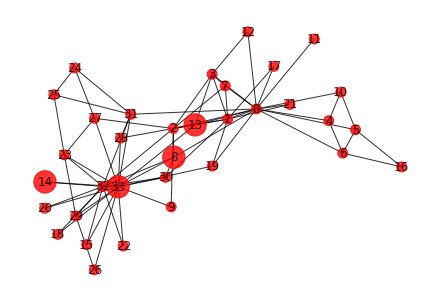

round 890000


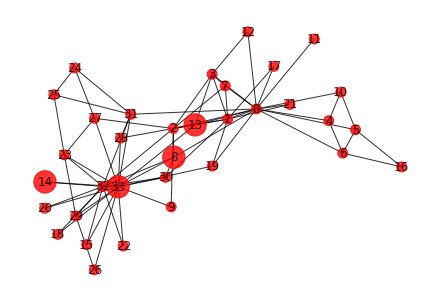

round 900000


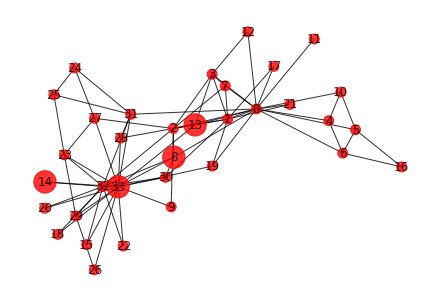

round 910000


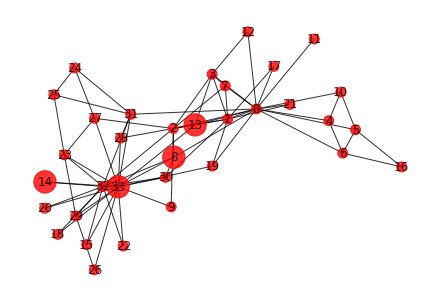

round 920000


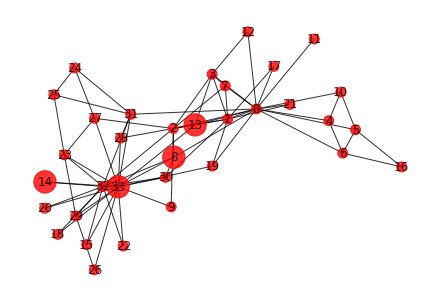

round 930000


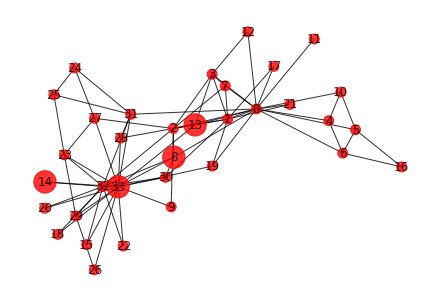

round 940000


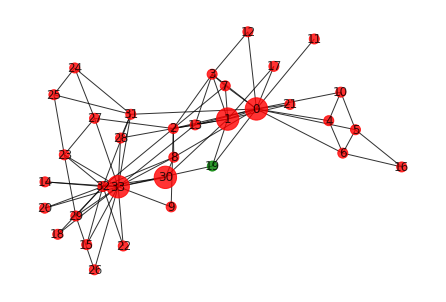

round 950000


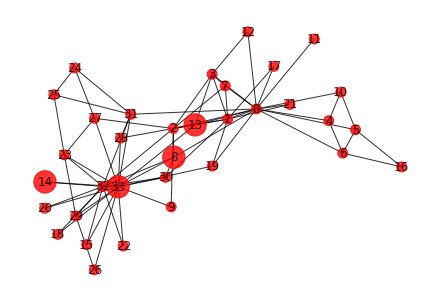

round 960000


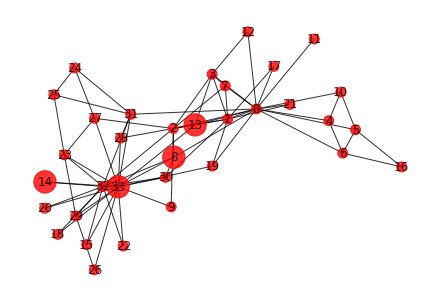

round 970000


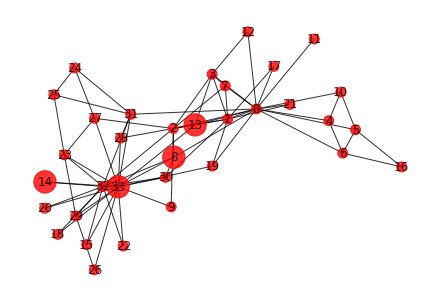

round 980000


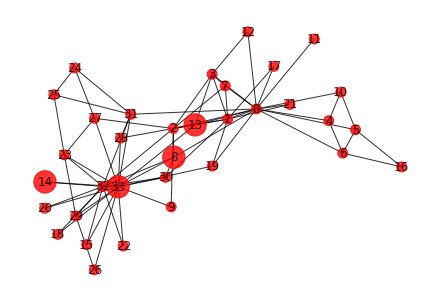

round 990000


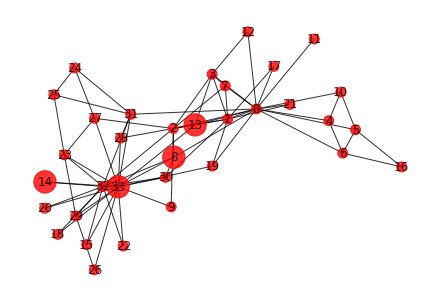

round 1000000


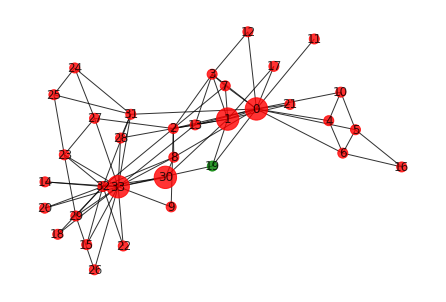

In [17]:
num_rounds = 10**6  # Play many more rounds
show_rounds = 10**4  # Only show some rounds
role_history = np.zeros([num_rounds + 1, G.number_of_nodes()])
# initialization
old_role = role.copy()
# save memory by replacing role_history with num_defectors
num_defectors = [sum(old_role)]  
for round in range(1, num_rounds + 1):
    # Play the game
    points = get_points(old_role, pts_DC = 1.4)
    new_role = get_new_mutrole(old_role, neighbors, points, 
                               G, p_m = 0.01)
    # Save results
    num_defectors.append(sum(new_role)) # less data used
    # Only show some rounds
    if round % show_rounds == 0:
        # Top 4 players
        points_rank = np.argsort(points)[::-1]
        best4 = points_rank[0:4]
        # Draw result
        print(f"round {round}")
        draw_defectors(G, pos, old_role, best4)
    # Update network
    old_role = new_role

In [29]:
no_defect = np.argwhere(np.array(num_defectors) == 0).flatten()
dt_no_defect = np.diff(no_defect)
dt_no_defect
no_defect

array([     1,      2,      3,      4, 702076, 702079, 702080, 702083,
       702084, 702085, 702086, 702087, 702088, 702089, 702090, 702091,
       702093, 702098, 702099, 702102, 702103, 702104, 702105, 702107,
       702108, 702109, 702110, 702111, 702112, 702113, 702115, 702117,
       702118, 702119, 702120, 702121, 702122, 702123, 702125, 702126,
       702127, 702128, 702129, 702130, 702131, 702133, 702135, 702136,
       702139, 702140, 702141, 702143, 702144, 702145, 702146, 702147,
       702149, 702150, 702153, 702156, 702157, 702158, 702159, 702160,
       702162, 702163, 702164, 702165, 702169, 702170, 702171, 702172,
       702174, 702175, 702176, 702177, 702178, 702179, 702180, 702181,
       913715, 913716, 913717, 913718, 913719, 913720, 913723, 913724,
       913725, 913727, 913729, 913730, 913731, 913733, 913734, 913735,
       913737, 913738, 913739, 913740, 913742, 913743, 913745, 913746,
       913747, 913748, 913749, 913756, 913757, 913759, 913760, 913761,
      

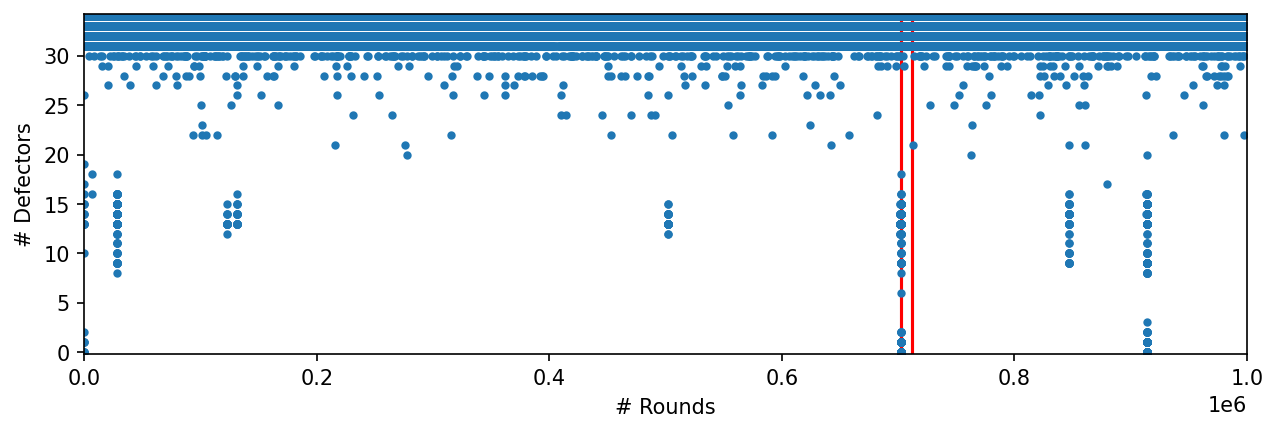

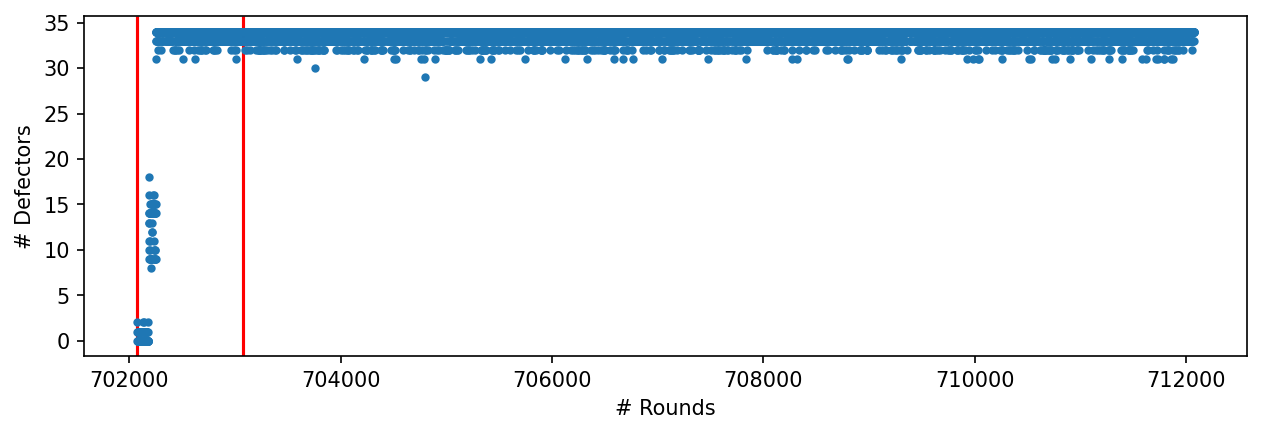

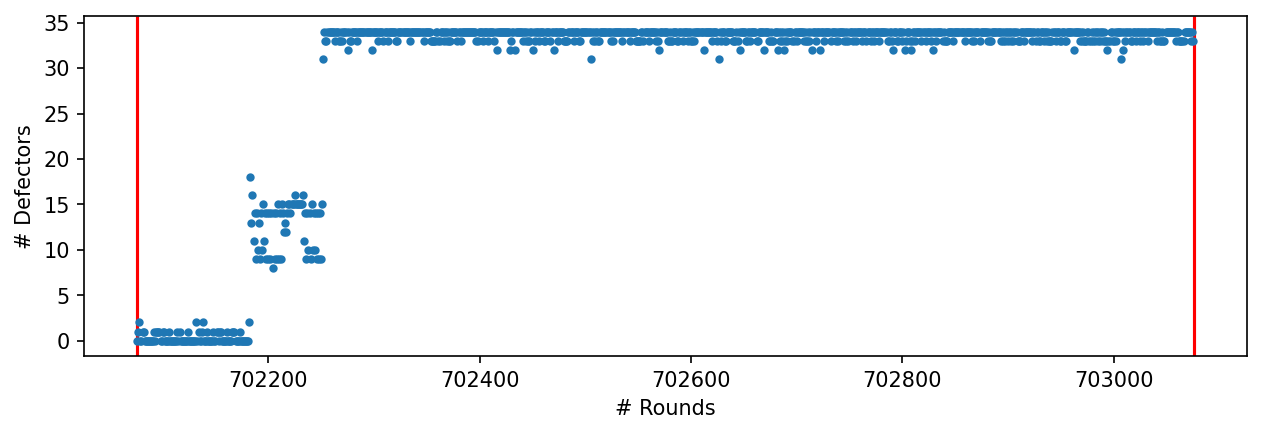

In [26]:
# x0 = int(0.7015*10**6)
x0 = 702076
dt1 = int(1*10**4)
dt2 = int(1*10**3)

t = np.array(range(len(num_defectors)))
fig, ax = plt.subplots(1, 1, figsize=[10, 3],
                               dpi=150)

ax.plot(t, num_defectors, '.')
ax.set_ylim([0-0.2, G.number_of_nodes()+0.2])
ax.set_xlim([0, num_rounds])
ax.set_xlabel('# Rounds')
ax.set_ylabel('# Defectors')
ymin, ymax = ax.get_ylim()
ax.vlines([x0, x0 + dt1], ymin, ymax, color='r')
ax.set_ylim([ymin, ymax])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=[10, 3],
                               dpi=150)
ax.plot(t[x0:x0+dt1],
        num_defectors[x0:x0+dt1], 
        '.')
ax.set_xlabel('# Rounds')
ax.set_ylabel('# Defectors')
ymin, ymax = ax.get_ylim()
ax.vlines([x0, x0 + dt2], ymin, ymax, color='r')
ax.set_ylim([ymin, ymax])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=[10, 3],
                               dpi=150)
ax.plot(t[x0:x0+dt2],
        num_defectors[x0:x0+dt2], 
        '.')
ax.set_xlabel('# Rounds')
ax.set_ylabel('# Defectors')
ymin, ymax = ax.get_ylim()
ax.vlines([x0, x0 + dt2], ymin, ymax, color='r')
ax.set_ylim([ymin, ymax])
plt.show()